In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

%matplotlib inline

# Получаем и обрабатываем данные

Скачать датасет можно [здесь](https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models) 

In [85]:
#!unzip archive.zip

In [3]:
DATA_DIR = Path("data")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
IMG_SIZE = 64

In [87]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [88]:
train_ds = ImageFolder(root=DATA_DIR,
                       transform=trans)

In [89]:
len(train_ds), train_ds[0][0].shape

(15747, torch.Size([3, 64, 64]))

Let's look at random image from dataset

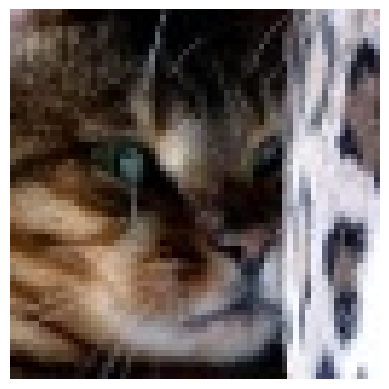

In [90]:
img = random.choice(train_ds)[0]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.show()

In [91]:
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              drop_last=True)
len(train_dataloader)

984

# Модели

In [92]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()).to(DEVICE)

In [93]:
discriminator(train_ds[0][0].to(DEVICE).unsqueeze(0))

tensor([[0.5723]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [4]:
LATENT_SPACE = 128

generator = nn.Sequential(

    nn.ConvTranspose2d(LATENT_SPACE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid()
).to(DEVICE)

In [95]:
test_img = generator(torch.from_numpy(np.random.randn(LATENT_SPACE, 1, 1)).unsqueeze(0).to(DEVICE).type(torch.float))
test_img.shape

torch.Size([1, 3, 64, 64])

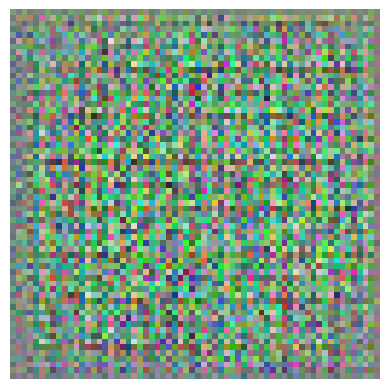

In [96]:
plt.imshow(test_img.squeeze(0).permute(1, 2, 0).cpu().detach())
plt.axis(False)
plt.show()

# Обучаем...

## **Обучение GAN:**
   1. Обучаем <span style="color: red;">*дискриминатор*</span>
   
      1.1 Даем на вход реальные изображения и получаем лосс

      1.2 Даем <span style="color: green;">*сгенерированные*</span> изображения и получаем лосс
      
      1.3 Суммируем лосс и обучаем
      
   2. Обучаем <span style="color: green;">*генератор*</span>
   
      2.1 Генерируем изображения
      
      2.2 Даем <span style="color: red;">*дискриминатору*</span> предсказать разметку
      
      2.3 Считаем лосс по разметке и обучаем

In [97]:
model = {
    "discriminator": discriminator,
    "generator": generator,
}
loss_fn = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss(),
}
optimizer = {
    "discriminator": torch.optim.Adam(params=discriminator.parameters(), lr=0.0002),
    "generator": torch.optim.Adam(params=generator.parameters(), lr=0.0002),
}

Epoch: 1 loss: 9.09699535369873
Epoch: 2 loss: 9.526154518127441
Epoch: 3 loss: 8.455792427062988
Epoch: 4 loss: 9.189257621765137
Epoch: 5 loss: 9.211231231689453


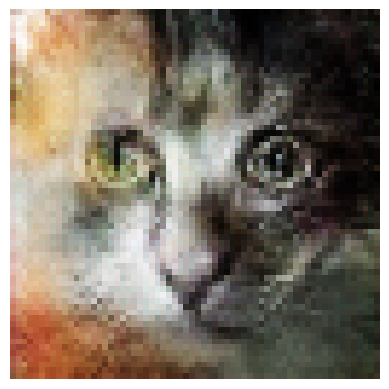

Epoch: 6 loss: 9.215991020202637
Epoch: 7 loss: 9.455883026123047
Epoch: 8 loss: 9.171378135681152
Epoch: 9 loss: 9.187681198120117
Epoch: 10 loss: 10.319700241088867


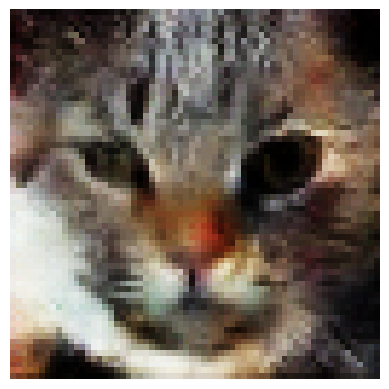

Epoch: 11 loss: 9.204267501831055
Epoch: 12 loss: 9.648411750793457
Epoch: 13 loss: 10.410965919494629
Epoch: 14 loss: 9.352563858032227
Epoch: 15 loss: 10.746232032775879


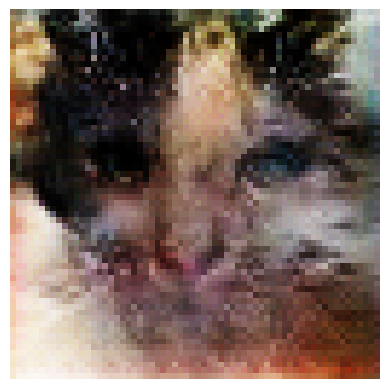

Epoch: 16 loss: 10.086913108825684
Epoch: 17 loss: 10.45985221862793
Epoch: 18 loss: 10.365368843078613
Epoch: 19 loss: 9.96381950378418
Epoch: 20 loss: 10.255167961120605


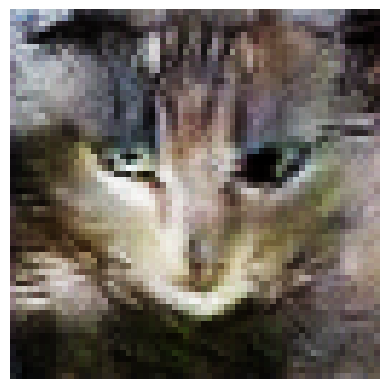

In [110]:
EPOCH = 40

for epoch in range(1, EPOCH + 1):

    model["discriminator"].train()
    model["generator"].train()

    loss_res = 0
    for real_img in train_dataloader:

        real_img = real_img[0].to(DEVICE)

        # 1.1 даем дискриминатору посчитать ошибку на настоящих данных
        real_pred = model["discriminator"](real_img)
        real_true = torch.ones((BATCH_SIZE, 1)).to(DEVICE)
        loss_d_on_real = loss_fn["discriminator"](real_pred, real_true)

        # 1.2 даем дискриминатору посчитать ошибку на сгенерированных данных
        fake_img = model["generator"](torch.randn((BATCH_SIZE, LATENT_SPACE, 1, 1)).to(DEVICE))
        fake_pred = model["discriminator"](fake_img)
        fake_true = torch.zeros((BATCH_SIZE, 1)).to(DEVICE)
        loss_d_on_fake = loss_fn["discriminator"](fake_pred, fake_true)

        # 1.3 суммируем и обучаем дискриминатор
        loss_d = loss_d_on_real + loss_d_on_fake
        optimizer["discriminator"].zero_grad()
        loss_d.backward()
        optimizer["discriminator"].step()

        # 2.1 генерируем изображения
        fake_img = model["generator"](torch.randn((BATCH_SIZE, LATENT_SPACE, 1, 1)).to(DEVICE))

        # 2.2 даем дискриминатору предсказать разметку
        fake_pred = model["discriminator"](fake_img)
        fake_true = torch.ones((BATCH_SIZE, 1)).to(DEVICE)

        # 2.3 обучаем генератор
        loss_g = loss_fn["generator"](fake_pred, fake_true)
        optimizer["generator"].zero_grad()
        loss_g.backward()
        optimizer["generator"].step()

        loss_res += loss_g

    print(f"Epoch: {epoch} loss: {loss_res / len(train_dataloader)}")
    
    if epoch % 5 == 0:
        model["generator"].eval
        with torch.inference_mode():
            fake_img = model["generator"](torch.randn((1, LATENT_SPACE, 1, 1)).to(DEVICE))
            plt.imshow(fake_img.squeeze(0).permute(1, 2, 0).cpu().detach())
            plt.axis(False)
            plt.show()

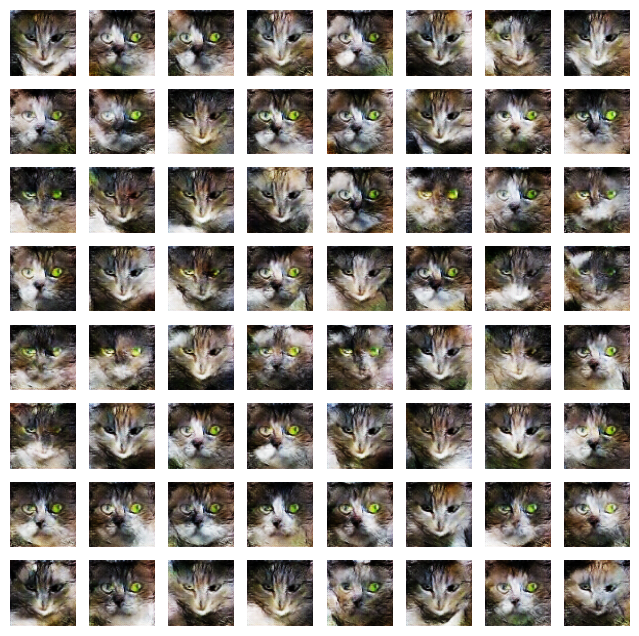

In [111]:
model["generator"].eval
with torch.inference_mode():
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    ax = ax.ravel()
    for i in range(64):
        fake_img = model["generator"](torch.randn((1, LATENT_SPACE, 1, 1)).to(DEVICE))
        ax[i].imshow(fake_img.squeeze(0).permute(1, 2, 0).cpu().detach())
        ax[i].axis(False)
    plt.show()

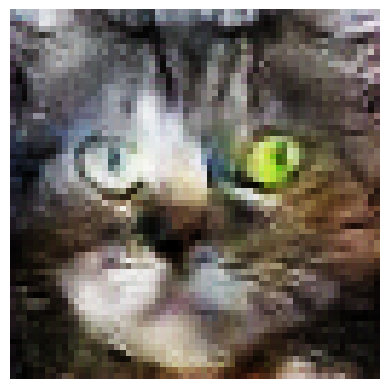

In [168]:
model["generator"].eval
with torch.inference_mode():
    fake_img = model["generator"](torch.randn((1, LATENT_SPACE, 1, 1)).to(DEVICE))
    plt.imshow(fake_img.squeeze(0).permute(1, 2, 0).cpu().detach())
    plt.axis(False)
    plt.show()

In [136]:
torch.save(generator.state_dict(), f="models/generator_1.pth")

In [ ]:
generator.load_state_dict(torch.load(f="models/generator_1.pth"))